1. See whether AI risk is better predicted with tasks
2. Combine tasks, skills and abilities to see if that leads to an even better prediction of AI risk
3. Create occupation clusters based on skills and abilities
4. Create occupation clusters based on tasks
5. See if grouping AI Risk into low, med, high would imporve the model (move from regression to classification)
6. Streamlit app:
- Drop down with occupation, which would provide a prediction of AI Risk
- Recommend similar jobs based on clusters that have a lower AI risk

In [1]:
pip install thefuzz

In [2]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

nltk.download('all')
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
import tensorflow as tf
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Bidirectional
from keras import backend as K

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)
from sklearn.compose import make_column_transformer
#pip install -U scikit-learn

## Import Data

In [8]:
tasks = pd.read_excel("Task Ratings.xlsx")

In [71]:
techskills = pd.read_excel("Technology Skills.xlsx")

In [7]:
taskstatements = pd.read_excel("Task Statements.xlsx")

In [5]:
ai_risk = pd.read_csv("My_Data.csv")

## Review the Data

In [7]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161847 entries, 0 to 161846
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   O*NET-SOC Code      161847 non-null  object 
 1   Title               161847 non-null  object 
 2   Task ID             161847 non-null  int64  
 3   Task                161847 non-null  object 
 4   Scale ID            161847 non-null  object 
 5   Scale Name          161847 non-null  object 
 6   Category            125881 non-null  float64
 7   Data Value          161847 non-null  float64
 8   N                   157374 non-null  float64
 9   Standard Error      121275 non-null  float64
 10  Lower CI Bound      109475 non-null  float64
 11  Upper CI Bound      109475 non-null  float64
 12  Recommend Suppress  123453 non-null  object 
 13  Date                161847 non-null  object 
 14  Domain Source       161847 non-null  object 
dtypes: float64(6), int64(1), object(8)

In [260]:
tasks.head()

,O*NET-SOC Code,Title,Task ID,Task,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),1.0,5.92,76.0,4.27,1.35,22.44,N,08/2023,Incumbent
1,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),2.0,15.98,76.0,5.60,7.65,30.40,N,08/2023,Incumbent
2,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),3.0,29.68,76.0,9.53,14.52,51.18,N,08/2023,Incumbent
3,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),4.0,21.18,76.0,8.39,8.99,42.23,N,08/2023,Incumbent
4,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),5.0,19.71,76.0,7.37,8.85,38.29,N,08/2023,Incumbent


In [261]:
taskstatements.head()

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,95.0,08/2023,Incumbent
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,95.0,08/2023,Incumbent
2,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,95.0,08/2023,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,94.0,08/2023,Incumbent
4,11-1011.00,Chief Executives,8834,Prepare or present reports concerning activiti...,Core,95.0,08/2023,Incumbent


In [10]:
techskills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32384 entries, 0 to 32383
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   O*NET-SOC Code   32384 non-null  object
 1   Title            32384 non-null  object
 2   Example          32384 non-null  object
 3   Commodity Code   32384 non-null  int64 
 4   Commodity Title  32384 non-null  object
 5   Hot Technology   32384 non-null  object
 6   In Demand        32384 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


In [11]:
#ai_risk.info()

### Reconfigure the dataset to be a crosstab

In [262]:
tasks_importance = tasks[tasks["Scale Name"] == "Importance"]

In [263]:
tasks_importance_1 = tasks[tasks["Category"] == 1]

In [264]:
tasks_importance_2 = tasks[tasks["Category"] == 2]

In [265]:
tasks_importance_3 = tasks[tasks["Category"] == 3]

In [266]:
tasks_importance_4 = tasks[tasks["Category"] == 4]

In [267]:
tasks_importance_5 = tasks[tasks["Category"] == 5]

In [268]:
tasks_importance_6 = tasks[tasks["Category"] == 6]

In [269]:
tasks_importance_7 = tasks[tasks["Category"] == 7]

Count how many entries (abilities and skills) there are per title in the dataset

In [20]:
## Number of Tasks
tasks_importance.shape[0]

17983

In [21]:
tasks_importance.columns.values

array(['O*NET-SOC Code', 'Title', 'Task ID', 'Task', 'Scale ID',
       'Scale Name', 'Category', 'Data Value', 'N', 'Standard Error',
       'Lower CI Bound', 'Upper CI Bound', 'Recommend Suppress', 'Date',
       'Domain Source'], dtype=object)

In [270]:
## Shorten the datasets for easier use
def drop_columns(x):
  x.drop(columns=['Title',
                  'Scale ID',
                  'Scale Name',
                  'Category',
                  'N',
                  'Standard Error',
                  'Lower CI Bound',
                  'Upper CI Bound',
                  'Recommend Suppress',
                  'Date',
                  'Domain Source'], inplace = True)


In [271]:
sources = [tasks_importance,
           tasks_importance_1,
           tasks_importance_2,
           tasks_importance_3,
           tasks_importance_4,
           tasks_importance_5,
           tasks_importance_6,
           tasks_importance_7]
for source in sources:
  drop_columns(source)


<ipython-input-270-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',
<ipython-input-270-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',
<ipython-input-270-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',
<ipython-input-270-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Create an SOC-Title Index for future use

In [28]:
tasks_importance.head()

,O*NET-SOC Code,Task ID,Task,Data Value
7,11-1011.00,8823,Direct or coordinate an organization's financi...,4.52
16,11-1011.00,8824,"Confer with board members, organization offici...",4.32
25,11-1011.00,8827,"Prepare budgets for approval, including those ...",4.30
34,11-1011.00,8826,"Direct, plan, or implement policies, objective...",4.24
43,11-1011.00,8834,Prepare or present reports concerning activiti...,4.17


In [272]:
tasks_importance_task_crosstab = tasks_importance.groupby("O*NET-SOC Code")["Task"].apply(','.join).reset_index()

Combine by Task and Occupation



In [273]:
tasks_importance_crosstab = pd.crosstab(tasks_importance["O*NET-SOC Code"], tasks_importance["Task ID"],
                                            values=tasks_importance["Data Value"], aggfunc='mean').round(1)

In [274]:
tasks_importance_crosstab.reset_index(inplace=True)

In [275]:
tasks_importance1_crosstab = pd.crosstab(tasks_importance_1["O*NET-SOC Code"], tasks_importance_1["Task ID"],
                                            values=tasks_importance_1["Data Value"], aggfunc='mean').round(1)

In [276]:
tasks_importance1_crosstab.reset_index(inplace=True)

In [277]:
tasks_importance2_crosstab = pd.crosstab(tasks_importance_2["O*NET-SOC Code"], tasks_importance_2["Task ID"],
                                            values=tasks_importance_2["Data Value"], aggfunc='mean').round(1)

In [278]:
tasks_importance2_crosstab.reset_index(inplace=True)

In [279]:
tasks_importance3_crosstab = pd.crosstab(tasks_importance_3["O*NET-SOC Code"], tasks_importance_3["Task ID"],
                                            values=tasks_importance_3["Data Value"], aggfunc='mean').round(1)

In [280]:
tasks_importance3_crosstab.reset_index(inplace=True)

In [281]:
tasks_importance4_crosstab = pd.crosstab(tasks_importance_4["O*NET-SOC Code"], tasks_importance_4["Task ID"],
                                            values=tasks_importance_4["Data Value"], aggfunc='mean').round(1)

In [282]:
tasks_importance4_crosstab.reset_index(inplace=True)

In [283]:
tasks_importance5_crosstab = pd.crosstab(tasks_importance_5["O*NET-SOC Code"], tasks_importance_5["Task ID"],
                                            values=tasks_importance_5["Data Value"], aggfunc='mean').round(1)

In [284]:
tasks_importance5_crosstab.reset_index(inplace=True)

In [285]:
tasks_importance6_crosstab = pd.crosstab(tasks_importance_6["O*NET-SOC Code"], tasks_importance_6["Task ID"],
                                            values=tasks_importance_6["Data Value"], aggfunc='mean').round(1)

In [286]:
tasks_importance6_crosstab.reset_index(inplace=True)

In [287]:
tasks_importance7_crosstab = pd.crosstab(tasks_importance_7["O*NET-SOC Code"], tasks_importance_7["Task ID"],
                                            values=tasks_importance_7["Data Value"], aggfunc='mean').round(1)

In [288]:
tasks_importance7_crosstab.reset_index(inplace=True)

In [252]:
full_1 = pd.merge(tasks_importance_crosstab, tasks_importance1_crosstab,
                  left_on = tasks_importance_crosstab.keys()[0],
                  right_on = tasks_importance1_crosstab.keys()[0],
                  how = "inner", suffixes = ["_importance", "_yearly"])

In [42]:
full_2 = pd.merge(full_1, tasks_importance2_crosstab,
                  left_on = full_1.keys()[0],
                  right_on = tasks_importance2_crosstab.keys()[0],
                  how = "inner")

In [43]:
full_3 = pd.merge(full_2, tasks_importance3_crosstab,
                  left_on = full_2.keys()[0],
                  right_on = tasks_importance3_crosstab.keys()[0],
                  how = "inner", suffixes = ["_more_yearly", "_more_monthly"])

In [44]:
full_4 = pd.merge(full_3, tasks_importance4_crosstab,
                  left_on = full_3.keys()[0],
                  right_on = tasks_importance4_crosstab.keys()[0],
                  how = "inner")

In [45]:
full_5 = pd.merge(full_4, tasks_importance5_crosstab,
                  left_on = full_4.keys()[0],
                  right_on = tasks_importance5_crosstab.keys()[0],
                  how = "inner", suffixes = ["_more_weekly", "_daily"])

In [46]:
full_6 = pd.merge(full_5, tasks_importance6_crosstab,
                  left_on = full_5.keys()[0],
                  right_on = tasks_importance6_crosstab.keys()[0],
                  how = "inner")

In [47]:
full_7 = pd.merge(full_6, tasks_importance7_crosstab,
                  left_on = full_6.keys()[0],
                  right_on = tasks_importance7_crosstab.keys()[0],
                  how = "inner", suffixes = ["_more_daily", "_hourly"])

In [ ]:
tasks.head()

In [50]:
tasks_grouped = tasks.drop_duplicates(["O*NET-SOC Code", "Title"])

In [ ]:
tasks_grouped.shape

In [51]:
full_dataset = full_7.merge(tasks_grouped[["O*NET-SOC Code","Title"]], left_on=["O*NET-SOC Code"], right_on=["O*NET-SOC Code"], how = "left" )

In [52]:
full_dataset_copy = full_dataset.fillna(0)

In [53]:
full_dataset_copy.shape

(873, 143866)

Combine level and importance for Abilities and Skills

##Clean up job titles in Occupations Dataset

In [9]:
title_ref = tasks[tasks["Scale Name"] == "Importance"].groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [10]:
title_ref_ = pd.DataFrame(title_ref)

In [11]:
title_ref_.reset_index()

,O*NET-SOC Code,Title
0,11-1011.00,[Chief Executives]
1,11-1011.03,[Chief Sustainability Officers]
2,11-1021.00,[General and Operations Managers]
3,11-2011.00,[Advertising and Promotions Managers]
4,11-2021.00,[Marketing Managers]
...,...,...
868,53-7071.00,[Gas Compressor and Gas Pumping Station Operat...
869,53-7072.00,"[Pump Operators, Except Wellhead Pumpers]"
870,53-7073.00,[Wellhead Pumpers]
871,53-7081.00,[Refuse and Recyclable Material Collectors]


In [12]:
title_ref_["Adj_title"] = title_ref_['Title'].agg(lambda x: ','.join(map(str, x)))

In [13]:
full_dataset_title = title_ref_["Adj_title"]

In [14]:
full_dataset_title_ = [re.split(r',|, and', x) for x in full_dataset_title]

In [15]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [16]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [17]:
for x in full_dataset_title_:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [18]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [19]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [20]:
exceptions = []
for x in full_dataset_title_:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

Split on "," and "and":

Split occupation titles on ", and " and ", "
Replace "ie" at the end of occupations with "y"
Strip "s" at the end of occupations (problems with certain fields like "gas" and "waitresses")
Trim leading spaces
Remove all words following "except"

In [21]:
full_dataset_title_split = pd.DataFrame(full_dataset_title_, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [22]:
title_ref_.reset_index()

,O*NET-SOC Code,Title,Adj_title
0,11-1011.00,[Chief Executives],Chief Executives
1,11-1011.03,[Chief Sustainability Officers],Chief Sustainability Officers
2,11-1021.00,[General and Operations Managers],General and Operations Managers
3,11-2011.00,[Advertising and Promotions Managers],Advertising and Promotions Managers
4,11-2021.00,[Marketing Managers],Marketing Managers
...,...,...,...
868,53-7071.00,[Gas Compressor and Gas Pumping Station Operat...,Gas Compressor and Gas Pumping Station Operators
869,53-7072.00,"[Pump Operators, Except Wellhead Pumpers]","Pump Operators, Except Wellhead Pumpers"
870,53-7073.00,[Wellhead Pumpers],Wellhead Pumpers
871,53-7081.00,[Refuse and Recyclable Material Collectors],Refuse and Recyclable Material Collectors


In [23]:
full_dataset_combined = full_dataset_title_split.merge(title_ref_.reset_index()[["Adj_title", "O*NET-SOC Code"]],
                                                          left_index = True, right_index = True, how="inner")

In [34]:
full_dataset_combined.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Adj_title           0
O*NET-SOC Code      0
dtype: int64

##Analyzing our dataset
Matching titles across datasets

Trying Fuzzy Match

In [24]:
full_dataset_combined["Match_Column"] = full_dataset_combined["Adj_title"]

In [25]:
full_dataset_combined.rename(columns={"Adj_title":"Title"},inplace=True)

In [26]:
full_dataset_combined.columns

Index(['Title1', 'Title2', 'Title3', 'Title4', 'Title5', 'Title6', 'Title7',
       'Title', 'O*NET-SOC Code', 'Match_Column'],
      dtype='object')

In [ ]:
#full_dataset_occupations_copy_titles.drop(columns = ["Unnamed: 0"], inplace=True)

In [29]:
ai_risk.columns

Index(['Job titiles', 'AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio',
       'Domain'],
      dtype='object')

In [27]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)

In [28]:
full_dataset_combined["Match_Column"]= full_dataset_combined["Title"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))


In [29]:
full_dataset_combined["Match_Column_unpacked"] = full_dataset_combined["Match_Column"].apply("|".join)

In [30]:
full_dataset_combined["Match_Ratio"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [31]:
full_dataset_combined["Match_Ratio_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [32]:
full_dataset_combined["Match_Column_1"]= full_dataset_combined["Title1"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x, ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))


In [33]:
full_dataset_combined["Match_Ratio_1"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_1, x.Title1), axis=1)

In [34]:
full_dataset_combined["Match_Ratio_1_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title1), axis=1)

In [35]:
full_dataset_combined["Match_Ratio_1b_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title), axis=1)

In [36]:
full_dataset_combined["Match_Ratio_1_tokens"].value_counts(ascending= False).head()

100    303
0      116
67      31
70      21
76      17
Name: Match_Ratio_1_tokens, dtype: int64

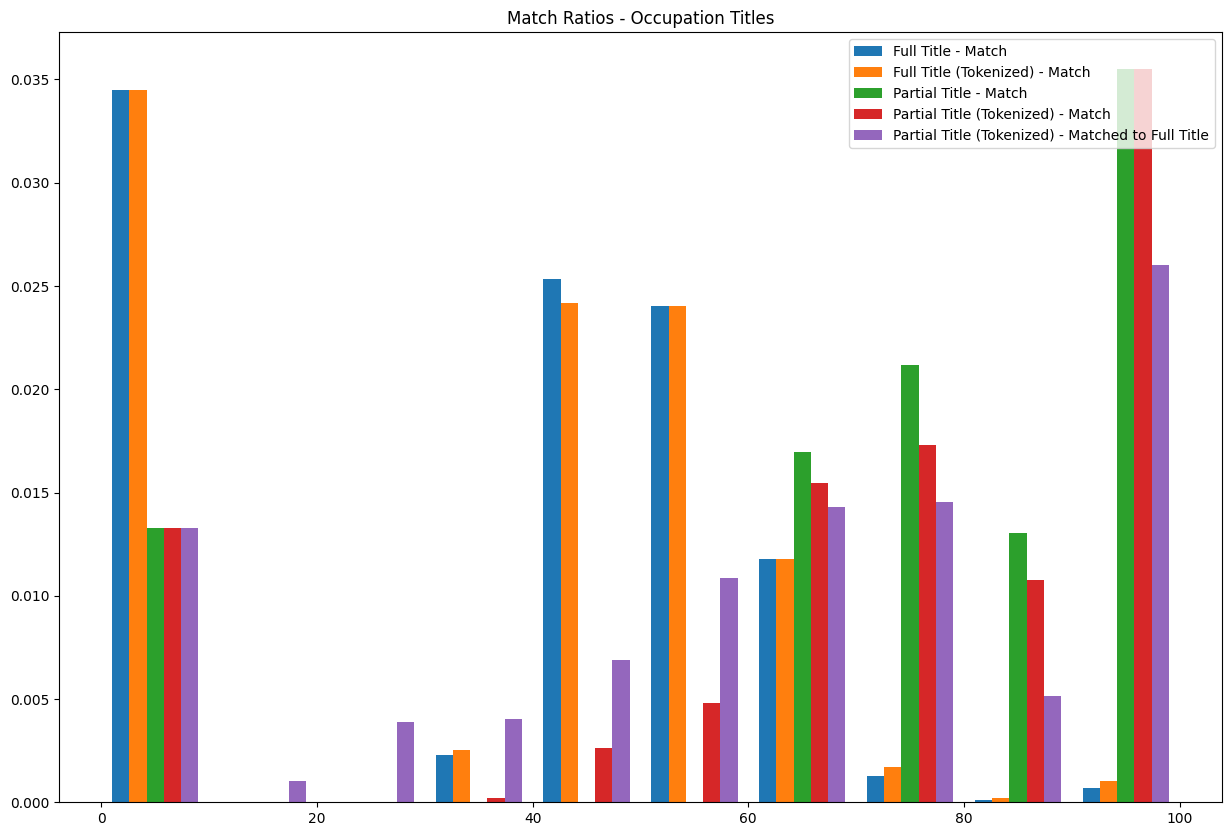

In [49]:
x = full_dataset_combined[["Match_Ratio", "Match_Ratio_tokens", "Match_Ratio_1","Match_Ratio_1_tokens","Match_Ratio_1b_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar')
plt.title('Match Ratios - Occupation Titles')
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match","Partial Title - Match", "Partial Title (Tokenized) - Match", "Partial Title (Tokenized) - Matched to Full Title"], loc ="upper right", fontsize = '10');

In [58]:
mean_similarity_tokens = np.mean(full_dataset_combined["Match_Ratio_1_tokens"])
mean_similarity_tokens

71.29209621993127

In [59]:
mean_similarity_ = np.mean(full_dataset_combined["Match_Ratio_1"])
mean_similarity_

73.07331042382589

## Feeding in the Target Values

In [37]:
def partial_match(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'AI Impact'].iloc[0]

In [38]:
def partial_match_(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'Job_title'].iloc[0]

In [39]:
full_dataset_combined["Match_Column_1"] = full_dataset_combined["Match_Column_1"].apply(lambda y: "" if y==[] else y)

In [40]:
full_dataset_combined_ = pd.merge(left=full_dataset_combined, right=ai_risk,
                                  left_on="Match_Column_1", right_on = "Job_title", how="left")

In [41]:
full_dataset_combined_.dropna(subset = ["AI Impact"], inplace=True)

In [42]:
full_dataset_combined_.rename(columns = {
    "AI Impact" : "aiimpact"
}, inplace = True)

In [43]:
full_dataset_combined_["aiimpact"].str.rstrip('%').astype(float)

0      10.0
1      90.0
2      24.0
3      75.0
4      45.0
       ... 
865    30.0
866    50.0
867    80.0
869    17.0
872    35.0
Name: aiimpact, Length: 757, dtype: float64

In [44]:
conditions = [
    (full_dataset_combined_["aiimpact"].str.rstrip('%').astype(float) >= 75),
    (full_dataset_combined_["aiimpact"].str.rstrip('%').astype(float) <= 25),
]

choices = ["high", "low"]

In [45]:
full_dataset_combined_["rank"] = np.select(conditions, choices, "med")


In [46]:
full_dataset_combined_["rank"] = full_dataset_combined_["rank"].astype('category')

In [47]:
full_dataset_combined_["rank_new"] = full_dataset_combined_["rank"].cat.codes

In [50]:
full_dataset_combined_.to_pickle("./title_match.pkl")

Experimenting with including Job Titles

In [210]:
stops = nltk.corpus.stopwords.words('english')
#new_stop_words = [""]
#stops.extend(new_stop_words)

In [87]:
def text_process(text):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [ ]:
df_lemm_task = full_dataset_combined_analysis["Task"].apply(text_process)
df_lemm_title = full_dataset_combined_analysis["Title"].apply(text_process)

Because the tasks are mutually exclusive by Occupation, it's difficult to use them as a predictor.

What about, if we use the words in the tasks to indicate AI risk?

In [157]:
tasks_for_model = pd.DataFrame(df_lemm)

In [211]:
titles_for_model = pd.DataFrame(df_lemm_title)

In [196]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm)
cvec_transform = cvec.transform(df_lemm)
tasks_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [212]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_title)
cvec_transformed = cvec.transform(df_lemm_title)
titles_lemmed = pd.DataFrame(cvec_transformed.todense(), columns=cvec.get_feature_names_out())

In [197]:
y_lemm = pd.DataFrame(ytask["rank"])
y_lemm = y_lemm.reset_index(drop=True)

In [198]:
tasks_lemmed_ = pd.merge(tasks_lemmed, y_lemm, left_index=True, right_index=True)


In [213]:
titles_lemmed_ = pd.merge(titles_lemmed, y_lemm, left_index=True, right_index=True)

In [206]:
filtered = full_dataset_combined_analysis[full_dataset_combined_analysis['Task'].str.contains("using hand tool")]
filtered.groupby("aiimpact")["Title"].apply(np.unique)

aiimpact
10%    [Actors, Cement Masons and Concrete Finishers,...
15%    [Biomass Power Plant Managers, Electrical and ...
17%    [Pump Operators, Except Wellhead Pumpers, Rous...
18%    [Farm Equipment Mechanics and Service Technici...
20%    [Aerospace Engineering and Operations Technolo...
25%    [Aircraft Structure, Surfaces, Rigging, and Sy...
30%    [Automotive Glass Installers and Repairers, Ca...
35%    [Aircraft Mechanics and Service Technicians, C...
37%                          [Mechanical Door Repairers]
40%    [Craft Artists, Mobile Heavy Equipment Mechani...
45%    [Broadcast Technicians, Heating, Air Condition...
48%        [Motorboat Mechanics and Service Technicians]
5%     [Coating, Painting, and Spraying Machine Sette...
50%    [Computer, Automated Teller, and Office Machin...
55%         [Avionics Technicians, Robotics Technicians]
60%    [Cutting, Punching, and Press Machine Setters,...
65%    [Electromechanical Equipment Assemblers, Power...
80%                   

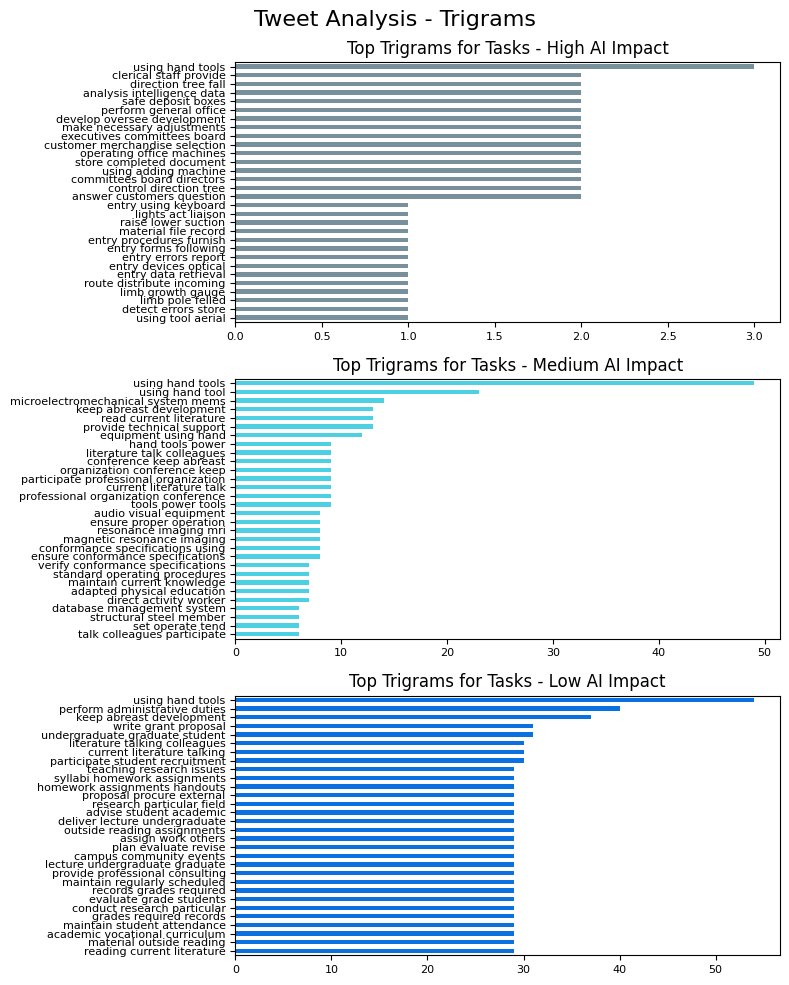

In [201]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

(tasks_lemmed_[tasks_lemmed_['rank'] == "high"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - High AI Impact', color='#78909c', fontsize=8, ax=axes[0])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank'] == "med"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - Medium AI Impact', color='#4dd0e1', fontsize=8, ax=axes[1])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank'] == "low"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - Low AI Impact', color='#0c71e0', fontsize=8, ax=axes[2])).invert_yaxis();


fig.suptitle('Tweet Analysis - Trigrams', fontsize=16);

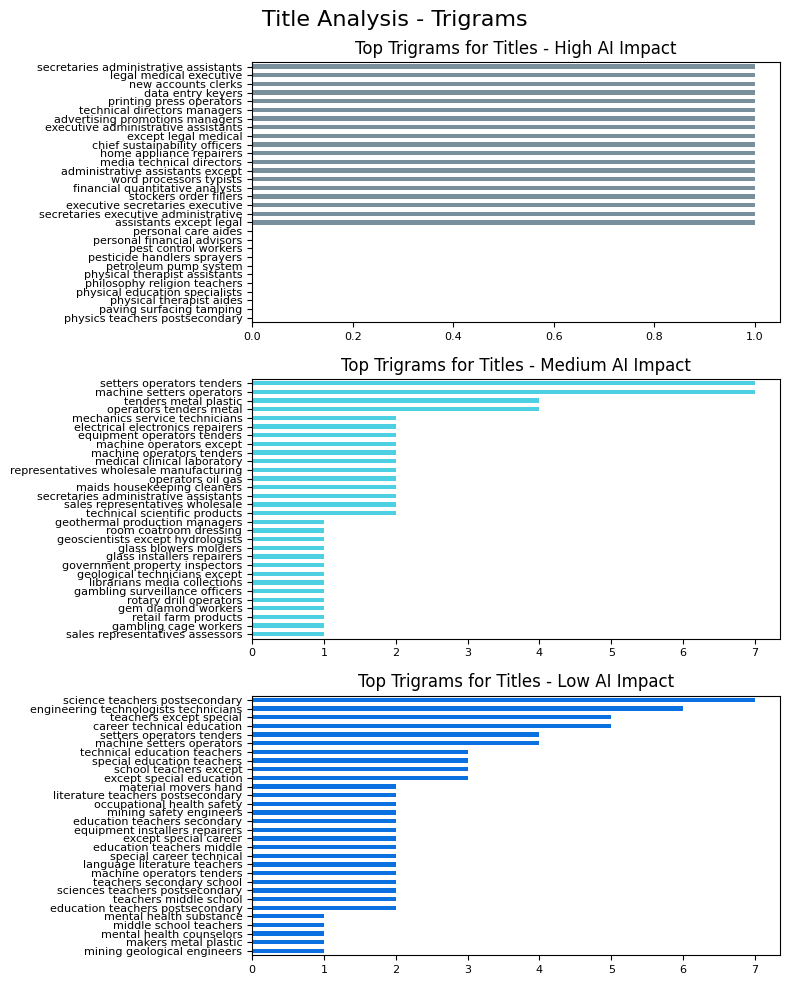

In [214]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

(titles_lemmed_[titles_lemmed_['rank'] == "high"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - High AI Impact', color='#78909c', fontsize=8, ax=axes[0])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank'] == "med"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - Medium AI Impact', color='#4dd0e1', fontsize=8, ax=axes[1])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank'] == "low"]
    .drop(columns=['rank'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - Low AI Impact', color='#0c71e0', fontsize=8, ax=axes[2])).invert_yaxis();


fig.suptitle('Title Analysis - Trigrams', fontsize=16);

In [235]:
basic_lookup_in_occupations_index = full_dataset_combined_analysis[full_dataset_combined_analysis["Title"].str.contains("Adhesive Bonding Machine")]
basic_lookup_in_occupations_index


,O*NET-SOC Code,Task,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,...,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens,Job_title,aiimpact,Tasks,AI models,AI_Workload_Ratio,Domain
815,51-9191.00,Align and position materials being joined to e...,Adhesive Bonding Machine Operator Tender,None,None,None,None,None,None,Adhesive Bonding Machine Operators and Tenders,...,Sewing Machine Operator,67,60,55,Sewing Machine Operator,25%,210.0,758.0,0.277045,Leadership & Strategy


In [325]:
#X = pd.concat([df_lemm_task, df_lemm_title], axis=1)

In [488]:
ytask = full_dataset_combined_analysis["rank_new"]

In [517]:
Xtask_train, Xtask_test, y_train, y_test = train_test_split(df_lemm_task,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [303]:
Xtitle_train, Xtitle_test, y_train, y_test = train_test_split(df_lemm_title,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [217]:
def evaluation(name_of_the_model, y_test, preds, gs_model, X_train, X_test):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test, y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

## Logistic Regression

1.   Count Vector - Task
2.  Count Vector - Title



In [211]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops],
}

In [307]:
pipe_cvec_logr_task = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [308]:
gs_task_cvec_logr = GridSearchCV(pipe_cvec_logr_task,
                pipe_params_cvec,
                  cv = 5)

In [309]:
gs_task_cvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [311]:
gs_task_cvec_logr_preds = gs_task_cvec_logr.predict(Xtask_test)

In [314]:
logistic_cvec = evaluation("Logistical Regression CVEC", y_test, gs_task_cvec_logr_preds, gs_task_cvec_logr, Xtask_train, Xtask_test)

In [315]:
logistic_cvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC,0.91,0.579,1.0,0.0,0.973,0.986


In [317]:
pipe_cvec_logr_title = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [318]:
gs_title_cvec_logr = GridSearchCV(pipe_cvec_logr_title,
                pipe_params_cvec,
                  cv = 5)

In [319]:
gs_title_cvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [320]:
gs_title_cvec_logr_preds = gs_title_cvec_logr.predict(Xtitle_test)

In [321]:
logistic_cvec_title = evaluation("Logistical Regression CVEC", y_test, gs_title_cvec_logr_preds, gs_title_cvec_logr, Xtitle_train, Xtitle_test)

In [322]:
logistic_cvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC,0.836,0.621,0.943,0.333,0.976,0.959


In [395]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [396]:
pipe_tvec_logr_task = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [397]:
gs_task_tvec_logr = GridSearchCV(pipe_tvec_logr_task,
                pipe_params_tvec,
                  cv = 5)

In [398]:
gs_task_tvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [399]:
gs_task_tvec_logr_preds = gs_task_tvec_logr.predict(Xtask_test)

In [400]:
logistic_tvec = evaluation("Logistical Regression TVEC", y_test, gs_task_tvec_logr_preds, gs_task_tvec_logr, Xtask_train, Xtask_test)

In [401]:
logistic_tvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC,0.982,0.547,0.903,0.5,0.985,0.942


In [402]:
pipe_tvec_logr_title = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [403]:
gs_title_tvec_logr = GridSearchCV(pipe_tvec_logr_title,
                pipe_params_tvec,
                  cv = 5)

In [405]:
gs_title_tvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [406]:
gs_title_tvec_logr_preds = gs_title_tvec_logr.predict(Xtitle_test)

In [407]:
logistic_tvec_title = evaluation("Logistical Regression TVEC ", y_test, gs_title_tvec_logr_preds, gs_title_tvec_logr, Xtitle_train, Xtitle_test)

In [408]:
logistic_tvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC,0.817,0.616,0.955,0.333,0.977,0.966


## Tech Skills

In [72]:
techskills.head()

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology,In Demand
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y,N
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N,N
2,11-1011.00,Chief Executives,Atlassian JIRA,43232201,Content workflow software,Y,N
3,11-1011.00,Chief Executives,Blackbaud The Raiser's Edge,43232303,Customer relationship management CRM software,N,N
4,11-1011.00,Chief Executives,ComputerEase construction accounting software,43231601,Accounting software,N,N


In [75]:
techskills.rename(columns = {"Example" : "Tool"}, inplace = True)

In [185]:
tech_merge = pd.merge(left = techskills, right = full_dataset_combined_,
                             left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [187]:
tech_df = tech_merge.groupby("O*NET-SOC Code")["Tool"].apply(np.unique)

In [188]:
tech_df.reset_index()

,O*NET-SOC Code,Tool
0,11-1011.00,"[AdSense Tracker, Adobe Systems Adobe Acrobat,..."
1,11-1011.03,"[Adobe Systems Adobe Acrobat, Adobe Systems Ad..."
2,11-1021.00,"[ADP Workforce Now, AMG Teleran SalesInSync, A..."
3,11-1031.00,"[Adobe Systems Adobe Acrobat, Adobe Systems Ad..."
4,11-2011.00,"[Actuate BIRT, AdRelevance, Adobe Systems Adob..."
...,...,...
918,53-7071.00,[Computerized maintenance management system CM...
919,53-7072.00,[Computerized maintenance management system CM...
920,53-7073.00,"[Microsoft Excel, Microsoft Office software, M..."
921,53-7081.00,"[AMCS Platform, Computerized maintenance manag..."


In [200]:
tech_df_ = pd.merge(left = tech_df, right =full_dataset_combined_,
                             left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [201]:
tech_df_filtered = tech_df_[tech_df_['rank_new'].notna()]

In [203]:
df_lemm_tool = tech_df_filtered["Tool"].apply(', '.join)

In [204]:
Xtool = df_lemm_tool

In [205]:
ytool = tech_df_filtered["rank_new"]

In [206]:
Xtool_train, Xtool_test, y_train, y_test = train_test_split(Xtool,
                                                    ytool,
                                                    random_state=42, stratify=ytool)

In [ ]:
ytool.value_counts(normalize=True)

In [212]:
pipe_cvec_logr_tool = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [213]:
gs_tool_cvec_logr = GridSearchCV(pipe_cvec_logr_task,
                pipe_params_cvec,
                  cv = 5)

In [214]:
gs_tool_cvec_logr.fit(Xtool_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [215]:
gs_tool_cvec_logr_preds = gs_tool_cvec_logr.predict(Xtool_test)

In [218]:
logistic_cvec_tool = evaluation("Logistical Regression TVEC - Tool", y_test, gs_tool_cvec_logr_preds, gs_tool_cvec_logr,
                                Xtool_train, Xtool_test)

In [219]:
logistic_cvec_tool

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Tool,0.628,0.579,1.0,0.0,0.961,0.98
